<a href="https://colab.research.google.com/github/4Freek/begginer_ML/blob/main/sentimentAnalisysTweetSpanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

files.upload()

Saving tweets.csv to tweets.csv


{'tweets.csv': b'\xef\xbb\xbfairline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone\r\nneutral,FALSE,0,0,Trabajar en #Ryanair como #TMA: https://t.co/ruUArBe1tO #empleo,,Fri Nov 03 12:05:12 +0000 2017,926419989107798016,,Madrid\r\nneutral,TRUE,0,0,@Iberia @FIONAFERRER Cuando gusten en Canc\xc3\xban se viaja y disfruta de manera sin igual,,Sun Nov 26 18:40:28 +0000 2017,934854385577943041,,Mexico City\r\nnegative,FALSE,0,0,"Sabiais que @Iberia te trata muy bien en santiago de chile?Te cambia el asiento,te manda a volar en el wc trasero,e\xe2\x80\xa6 https://t.co/uansbOnn69",,Mon Dec 25 15:40:45 +0000 2017,945318406441635840,,Madrid\r\nnegative,FALSE,0,0,"NUNCA NUNCA NUNCA pid\xc3\xa1is el caf\xc3\xa9 de Ryanair.\nBueno, nada que vendan a bordo.",,Mon Nov 06 14:18:35 +0000 2017,927540721296568320,,Pacific Time (US & Canada)\r\npositive,TRUE,0,0,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFGoodrichEU @BurgosTur @ASTIntlogi

In [100]:
import pandas as pd
import numpy as np
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, SpatialDropout1D, Dense, Embedding

In [80]:
df = pd.read_csv('/content/tweets.csv', sep=',', skip_blank_lines=True) # fijandonos en el archivo notamos que los valores estan separados por comas

In [81]:
df = df[['airline_sentiment', 'text']] # tomamos las columnas de nuestro interes

In [82]:
df.rename(columns={
    'airline_sentiment': 'sentimiento',
    "text": 'tweet'
}, inplace=True) # renombramos por gusto las columnas

In [78]:
df.head()

,sentimiento,tweet
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...
2,negative,Sabiais que @Iberia te trata muy bien en santi...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...


In [85]:
df['sentimiento'] = df['sentimiento'].map({
    'positive': 'positivo',
    'negative': 'negativo',
    'neutral': 'neutral',
    np.nan: 'neutral'
}, na_action=None) # mapeamos los sentimientos en valores de -1 a 1 siendo 0 un valor neutral

In [86]:
df.head()

,sentimiento,tweet
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...
2,negativo,Sabiais que @Iberia te trata muy bien en santi...
3,negativo,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...
4,positivo,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...


In [87]:
def clean_tweet(tweet):
  #re.sub("cadena a buscar", "con la que se reemplaza", cadena_leida)
  url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
          '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  menciones = '@[\w\-]+'
  hashtag = '#[\w\-]+'
  caracteres_especiales = r'\W'
  caracter_individual=r'\s+[a-zA-Z]\s+'
  caracter_individual_inicio= r'\^[a-zA-Z]\s+'
  varios_espacios= r'\s+'
  prefijo_b = r'^b\s+'
  numeros = '[0-9]+'

  tweet = tweet.lower()  #Convertir a minúsculas
  tweet = re.sub(menciones, ' ', tweet)
  tweet = re.sub(hashtag, ' ', tweet)
  tweet = re.sub(url, ' ', tweet)
  tweet = re.sub(caracteres_especiales, ' ', tweet)
  tweet = re.sub(caracter_individual, ' ', tweet)
  tweet = re.sub(caracter_individual_inicio, ' ', tweet) 
  tweet = re.sub(prefijo_b, '', tweet)
  tweet = re.sub(numeros, ' ', tweet)
  # tweet = re.sub(" rt | amp ", ' ', tweet)
  # tweet = re.sub(" q ", ' que ', tweet)
  # tweet = re.sub(" sr ", ' señor ', tweet)
  # tweet = re.sub(" x ", ' por ', tweet)
  # tweet = re.sub(" d ", ' de ', tweet)
  # tweet = re.sub(" xq ", ' porque ', tweet)
  tweet = re.sub(varios_espacios, ' ', tweet, flags=re.I)
      
  return  tweet  #retorna el tweet limpio

In [88]:
df['tweet'] = df['tweet'].apply(lambda x: x.lower())
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [89]:
df['tweet']

0       trabajar en ryanair como tma httpstcoruuarbe1t...
1       iberia fionaferrer cuando gusten en cancn se v...
2       sabiais que iberia te trata muy bien en santia...
3       nunca nunca nunca pidis el caf de ryanair\nbue...
4       cristortu dakar iberia mitsubishies bfgoodrich...
                              ...                        
7862    iberia iberiaexpress especialistas en dejarte ...
7863    con iberia mi destino a un solo click deseadme...
7864                       iberia muy bien muchas gracias
7865    es que volar con ryanair es peor que irte a ch...
7866    iberia inaugura un nuevo espacio premium para ...
Name: tweet, Length: 7867, dtype: object

In [90]:
df = df[df['sentimiento'] != 'neutral']

In [93]:
print(df[df['sentimiento'] == 'positivo'].size)
print(df[df['sentimiento'] == 'negativo'].size)

2978
7538


In [95]:
num_words = 2000

In [98]:
tokenizer = Tokenizer(num_words=num_words, split=' ')
tokenizer.fit_on_texts(df['tweet'].values)
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X)

In [99]:
embed_dim = 128
lstm_out = 196

In [101]:
model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(.4))
model.add(LSTM(lstm_out, dropout=.2, recurrent_dropout=.2))
model.add(Dense(2, activation='softmax'))

In [102]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 29, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 29, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_5 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [103]:
Y = pd.get_dummies(df['sentimiento'].values)

In [104]:
Y

,negativo,positivo
0,1,0
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
5253,1,0
5254,1,0
5255,0,1
5256,1,0


In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=42)

In [109]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3522, 29) (3522, 2)
(1736, 29) (1736, 2)


In [111]:
batch_size = 32

In [112]:
history = model.fit(X_train, Y_train, epochs=7, batch_size=batch_size, verbose=2)

Epoch 1/7
111/111 - 20s - loss: 0.5238 - accuracy: 0.7430 - 20s/epoch - 178ms/step
Epoch 2/7
111/111 - 20s - loss: 0.3964 - accuracy: 0.8271 - 20s/epoch - 177ms/step
Epoch 3/7
111/111 - 17s - loss: 0.3232 - accuracy: 0.8566 - 17s/epoch - 154ms/step
Epoch 4/7
111/111 - 17s - loss: 0.2781 - accuracy: 0.8827 - 17s/epoch - 154ms/step
Epoch 5/7
111/111 - 21s - loss: 0.2361 - accuracy: 0.8972 - 21s/epoch - 187ms/step
Epoch 6/7
111/111 - 17s - loss: 0.2068 - accuracy: 0.9120 - 17s/epoch - 154ms/step
Epoch 7/7
111/111 - 20s - loss: 0.1766 - accuracy: 0.9236 - 20s/epoch - 178ms/step


In [113]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

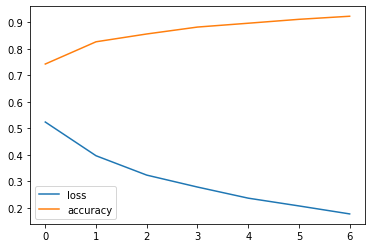

In [114]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [117]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))



8/8 - 1s - loss: 0.6009 - accuracy: 0.7924 - 709ms/epoch - 89ms/step
score: 0.60
acc: 0.79


In [119]:
def sentiment_analysis(tweet):
  #vectorizing the tweet by the pre-fitted tokenizer instance
  twt = tokenizer.texts_to_sequences([tweet])
  #padding the tweet to have exactly the same shape as `embedding_2` input
  twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
  # print(twt) imprime la secuencia del vector
  sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
  if(np.argmax(sentiment) == 0):
      print("negative")
  elif (np.argmax(sentiment) == 1):
      print("positive")



In [122]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    try:
      if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
      if np.argmax(Y_validate[x]) == 0:
          neg_cnt += 1
      else:
          pos_cnt += 1
    except KeyError:
      continue



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")


1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 61ms/epoch - 61ms/step
1/1 - 0s - 69ms/epoch - 69ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 83ms/epoch - 83ms/step
1/1 - 0s - 87ms/epoch - 87ms/step
1/1 - 0s - 58ms/epoch - 58ms/step
1/1 - 0s - 76ms/epoch - 76ms/step
1/1 - 0s - 50ms/epoch - 50ms/step
1/1 - 0s - 54ms/epoch - 54ms/step
1/1 - 0s - 67ms/epoch - 67ms/step
1/1 - 0s - 96ms/epoch - 96ms/step
1/1 - 0s - 49ms/epoch - 49ms/step
1/1 - 0s - 58ms/epoch - 58ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 81ms/epoch - 81ms/step
1/1 - 0s - 51ms/epoch - 51ms/step
1/1 - 0s - 55ms/epoch - 55ms/step
1/1 - 0s - 70ms/epoch - 70ms/step
1/1 - 0s - 50ms/epoch - 50ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38m

ZeroDivisionError: ignored

In [120]:
sentiment_analysis('Me siento algo cansado y triste!')

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   14  761  217  715    6
  1391]]
1/1 - 0s - 27ms/epoch - 27ms/step
negative


In [ ]:
sentiment_analysis('Me siento super feliz')